# Transformaciones inversas y aumentaciones en tiempo de prueba
Este cuaderno demuestra el uso de transformaciones invertibles. Más adelante, también veremos cómo realizar las transformaciones inversas en un lote de datos y cómo aprovecharlas para realizar aumentaciones en tiempo de prueba.

### ¿Qué son las transformaciones?

- Usamos transformaciones para modificar datos. En MONAI, las utilizamos para (por ejemplo) cargar imágenes desde archivos, añadir un componente de canal, normalizar las intensidades y redimensionar la imagen.
- También podemos usar las transformaciones como un método de aumento de datos: como tenemos una cantidad finita de datos, para evitar el sobreajuste, podemos aplicar transformaciones aleatorias para modificar nuestros datos en cada época.
- Ejemplos de transformaciones aleatorias pueden ser volteos, rotaciones, recortes, rellenos, zooms aleatorios, así como deformaciones no rígidas.

### Transformaciones inversas

- Tras aplicar transformaciones (aleatorias o no) a nuestros datos, a menudo puede ser útil devolverlos a su espacio original. Por ejemplo, podrías querer usar una red para segmentar una imagen y luego querrás que esa imagen segmentada esté en el mismo espacio que la de entrada para poder compararlas. Así podrías guardarlas en un archivo y compararlas en tu visor de imágenes médicas favorito.
- En MONAI, la mayoría de las transformaciones espaciales son invertibles. Puedes comprobarlo con `isinstance(x, InvertibleTransform)`.

### Aumentaciones en tiempo de prueba

- Si tu red incluye transformaciones aleatorias, puede que quieras observar el efecto que estas transformaciones tienen en la salida.
- Para ello, podrías pasar la misma entrada por la red varias veces, usando diferentes realizaciones aleatorias. Luego podrías usar las transformaciones inversas para llevar todos los resultados a un espacio común y calcular las métricas.
- Este es el propósito de `TestTimeAugmentation` de MONAI, que por defecto calculará la moda, media, desviación estándar y el coeficiente de variación de volumen. Para más información, consulta https://doi.org/10.1016/j.neucom.2019.01.103.

### Este cuaderno

Por rapidez, usaremos un conjunto de datos 2D aquí, aunque el flujo de trabajo sería idéntico para datos 3D.

Generaremos los datos tomando el conjunto de datos 3D de tumores cerebrales de Decathlon, seleccionando la rebanada 2D que contiene más vóxeles > 0 (la de mayor etiqueta), y luego guardando el nuevo conjunto de datos en disco.

Después, haremos un entrenamiento 2D normal con algunas aumentaciones, lo que nos permitirá beneficiarnos de las transformaciones inversas.

## Configurar el entorno

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Configurar importaciones

In [2]:
from glob import glob
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import random
import tempfile
import torch
from tqdm import tqdm

import monai
from monai.apps import download_and_extract
from monai.data import (
    CacheDataset,
    DataLoader,
    Dataset,
    pad_list_data_collate,
    TestTimeAugmentation,
)
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks import eval_mode
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    EnsureChannelFirstd,
    AsDiscrete,
    Compose,
    CropForegroundd,
    DivisiblePadd,
    KeepLargestConnectedComponent,
    Lambdad,
    LoadImaged,
    MapTransform,
    RandAffined,
    ScaleIntensityd,
    BatchInverseTransform,
)
from monai.transforms.utils import allow_missing_keys_mode
from monai.utils import first, set_determinism

monai.config.print_config()

# Set deterministic training for reproducibility
set_determinism(seed=0)

MONAI version: 1.5.0
Numpy version: 2.3.1
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d388d1c6fec8cb3a0eebee5b5a0b9776ca59ca83
MONAI __file__: /home/<username>/Workspace/Medical-Image-PGTD/.venv/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.4
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.16.0
Pillow version: 11.3.0
Tensorboard version: 2.19.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: 1.7.2
psutil version: 7.0.0
pandas version: 2.3.1
einops version: 0.8.1
transformers version: 4.53.2
mlflow version: 3.1.1
pynrrd version: 1.1.3
clearml version: 2.0.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Configurar directorio de datos

Puedes especificar un directorio con la variable de entorno `MONAI_DATA_DIRECTORY`.  
Esto te permite guardar resultados y reutilizar descargas.  
Si no se especifica, se usará un directorio temporal.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir ="/tmp/tmpwnmq4x11/"
print(root_dir)

/tmp/tmpwnmq4x11/


## Crear datos

Obtener datos, seleccionar la rebanada 2D con más vóxeles > 0 (más etiqueta) y guardar.

In [4]:
task = "Task09_Spleen"
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/" + task + ".tar"

compressed_file = os.path.join(root_dir, task + ".tar")
data_dir = os.path.join(root_dir, task)
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir)

images = sorted(glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
labels = sorted(glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image, "label": label} for image, label in zip(images, labels)]

In [5]:
class SliceWithMaxNumLabelsd(MapTransform):
    def __init__(self, keys, label_key):
        self.keys = keys
        self.label_key = label_key

    def __call__(self, data):
        d = dict(data)
        im = d[self.label_key]
        q = np.sum((im.array > 0).reshape(-1, im.array.shape[-1]), axis=0)
        _slice = np.where(q == np.max(q))[0][0]
        for key in self.keys:
            d[key] = d[key][..., _slice]
        return d


class SaveSliced(MapTransform):
    def __init__(self, keys, path):
        self.keys = keys
        self.path = path

    def __call__(self, data):
        d = {}
        for key in self.keys:
            fname = os.path.basename(data[key].meta["filename_or_obj"])
            path = os.path.join(self.path, key, fname)
            nib.save(nib.Nifti1Image(data[key].array, np.eye(4)), path)
            d[key] = path
        return d


keys = ["image", "label"]
data_dir = os.path.join(root_dir, task + "_single_slice")
for key in keys:
    os.makedirs(os.path.join(data_dir, key), exist_ok=True)
transform_2d_slice = Compose(
    [
        LoadImaged(keys),
        EnsureChannelFirstd(keys),
        SliceWithMaxNumLabelsd(keys, "label"),
        SaveSliced(keys, data_dir),
    ]
)
# Running the whole way through the dataset will create the 2D slices and save to file
ds_2d = Dataset(data_dicts, transform_2d_slice)
dl_2d = DataLoader(ds_2d, batch_size=1, num_workers=10)
data_dicts_single_slice = list(tqdm(dl_2d))

100%|██████████| 41/41 [00:06<00:00,  6.62it/s]


In [6]:
random.shuffle(data_dicts_single_slice)
num_files = len(data_dicts_single_slice)
num_train_files = round(0.8 * num_files)
train_files = data_dicts_single_slice[:num_train_files]
val_files = data_dicts_single_slice[num_train_files:]
print("total num files:", len(data_dicts_single_slice))
print("num training files:", len(train_files))
print("num validation files:", len(val_files))

total num files: 41
num training files: 33
num validation files: 8


In [33]:
train_transforms = Compose(
    [
        LoadImaged(keys),
        Lambdad("label", lambda x: (x > 0).to(torch.float)),
        RandAffined(
            keys,
            prob=1.0,
            spatial_size=(300,300),
            rotate_range=(np.pi / 3, np.pi / 3),
            translate_range=(3, 3),
            scale_range=((0.8, 1), (0.8, 1)),
            padding_mode="zeros",
            mode=("bilinear", "nearest"),
        ),
        CropForegroundd(keys, source_key="image", allow_smaller=True),
        DivisiblePadd(keys, 16),
        ScaleIntensityd("image"),
    ]
)
val_transforms = train_transforms

In [34]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, num_workers=10, collate_fn=pad_list_data_collate)
val_ds = CacheDataset(data=val_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=10, collate_fn=pad_list_data_collate)

Loading dataset: 100%|██████████| 8/8 [00:00<00:00, 99.68it/s]


## Mostrar algunos ejemplos

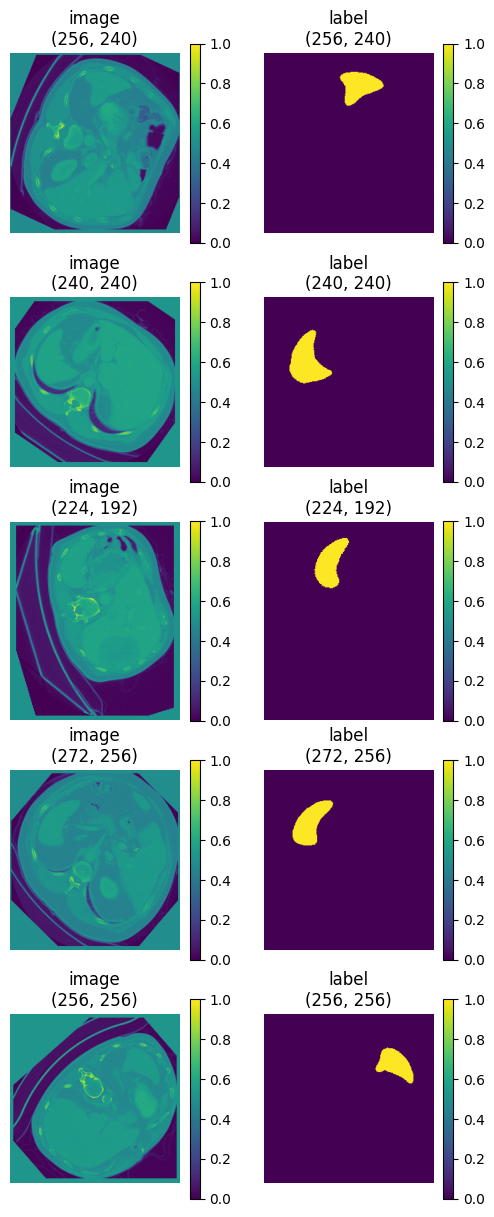

In [35]:
def imshows(ims):
    nrow = len(ims)
    ncol = len(ims[0])
    fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * 3, nrow * 3), facecolor="white")
    for i, im_dict in enumerate(ims):
        for j, (title, im) in enumerate(im_dict.items()):
            if isinstance(im, torch.Tensor):
                im = im.detach().cpu().numpy()
            im = np.mean(im, axis=0)  # average across channels
            if len(ims) == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]
            ax.set_title(f"{title}\n{im.shape}")
            im_show = ax.imshow(im)
            ax.axis("off")
            fig.colorbar(im_show, ax=ax)
    plt.show()
    
to_imshow = []
for file in np.random.choice(train_files, size=5, replace=False):
    data = train_transforms(file)
    to_imshow.append({"image": data["image"], "label": data["label"]})
imshows(to_imshow)

In [36]:
# Function for live plotting whilst running training
def plot_range(data, wrapped_generator):
    # Get ax, show plot, etc.
    plt.ion()
    for d in data.values():
        ax = d["line"].axes
    fig = ax.get_figure()
    fig.show()

    for i in wrapped_generator:
        yield i
        # update plots, legend, view
        for d in data.values():
            d["line"].set_data(d["x"], d["y"])
        ax.legend()
        ax.relim()
        ax.autoscale_view()
        fig.canvas.draw()

In [37]:
post_trans = Compose(
    [
        Activations(sigmoid=True),
        AsDiscrete(threshold=0.5),
        KeepLargestConnectedComponent(applied_labels=1),
    ]
)


def infer_seg(images, model, roi_size=(96, 96), sw_batch_size=4):
    val_outputs = sliding_window_inference(images, roi_size, sw_batch_size, model)
    return pad_list_data_collate([post_trans(i) for i in val_outputs])


# Create network, loss fn., etc.
dice_metric = DiceMetric(include_background=True, reduction="mean")
in_channels = train_ds[0]["image"].shape[0]
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=2,
    in_channels=in_channels,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
loss_function = DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [38]:
%matplotlib notebook
best_model_path = "best_model_inverse_transforms.pth"
skip_training_if_poss = False
skip_training = skip_training_if_poss and os.path.isfile(best_model_path)

if not skip_training:
    # Plotting stuff
    fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor="white")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Metric")

    data = {}
    for i in ["train", "val dice"]:
        data[i] = {"x": [], "y": []}
        (data[i]["line"],) = ax.plot(data[i]["x"], data[i]["y"], label=i)

    # start a typical PyTorch training
    max_epochs = 30
    val_interval = 1
    best_metric = -1
    best_metric_epoch = -1

    for epoch in plot_range(data, range(max_epochs)):
        model.train()
        epoch_loss = 0

        for batch_data in train_loader:
            inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        data["train"]["x"].append(epoch + 1)
        data["train"]["y"].append(epoch_loss)

        if (epoch + 1) % val_interval == 0:
            with eval_mode(model):
                val_outputs = None
                for val_data in val_loader:
                    val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                    val_outputs = infer_seg(val_images, model)
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                data["val dice"]["x"].append(epoch + 1)
                data["val dice"]["y"].append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), best_model_path)

    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

<IPython.core.display.Javascript object>

train completed, best_metric: 0.3185 at epoch: 20


In [39]:
model.load_state_dict(torch.load(best_model_path, weights_only=True))
_ = model.eval()

## Verificar segmentaciones

Cargar archivos de validación, aplicar transformaciones de validación y mostrar (¡aún sin inversas!).

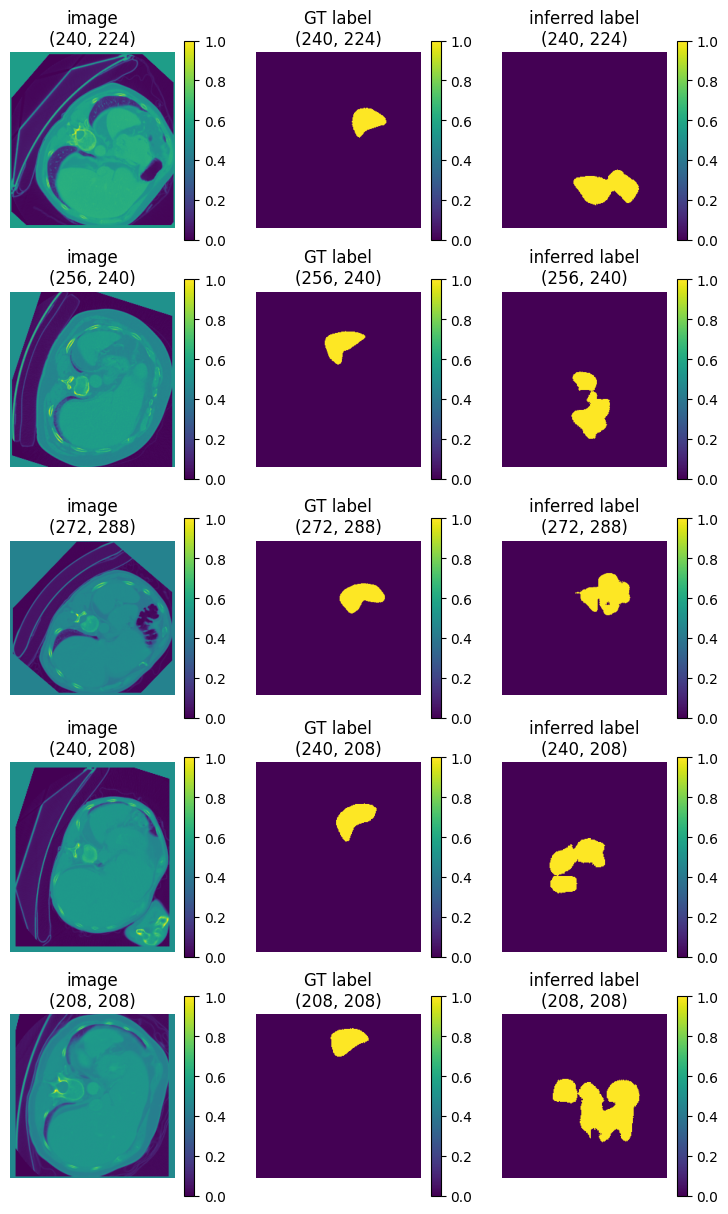

In [40]:
%matplotlib inline
to_imshow = []
for file in np.random.choice(val_files, size=5, replace=False):
    data = val_transforms(file)
    inferred = infer_seg(pad_list_data_collate([data["image"].to(device)]), model)[0]
    to_imshow.append(
        {
            "image": data["image"],
            "GT label": data["label"],
            "inferred label": inferred,
        }
    )
imshows(to_imshow)

## Transformación inversa

Aquí queremos realizar la inversa sobre un volumen segmentado. Las transformaciones que queremos invertir son las que se aplicaron a `label`, que están almacenadas bajo la clave `label_transforms`. Así que creamos un nuevo diccionario, con `label` igual a nuestro volumen segmentado inferido.

Al llamar a la inversa, usamos `with allow_missing_keys_mode`, ya que las transformaciones se configuraron con `keys=["image", "label"]` y solo queremos realizar la inversa en `label`.

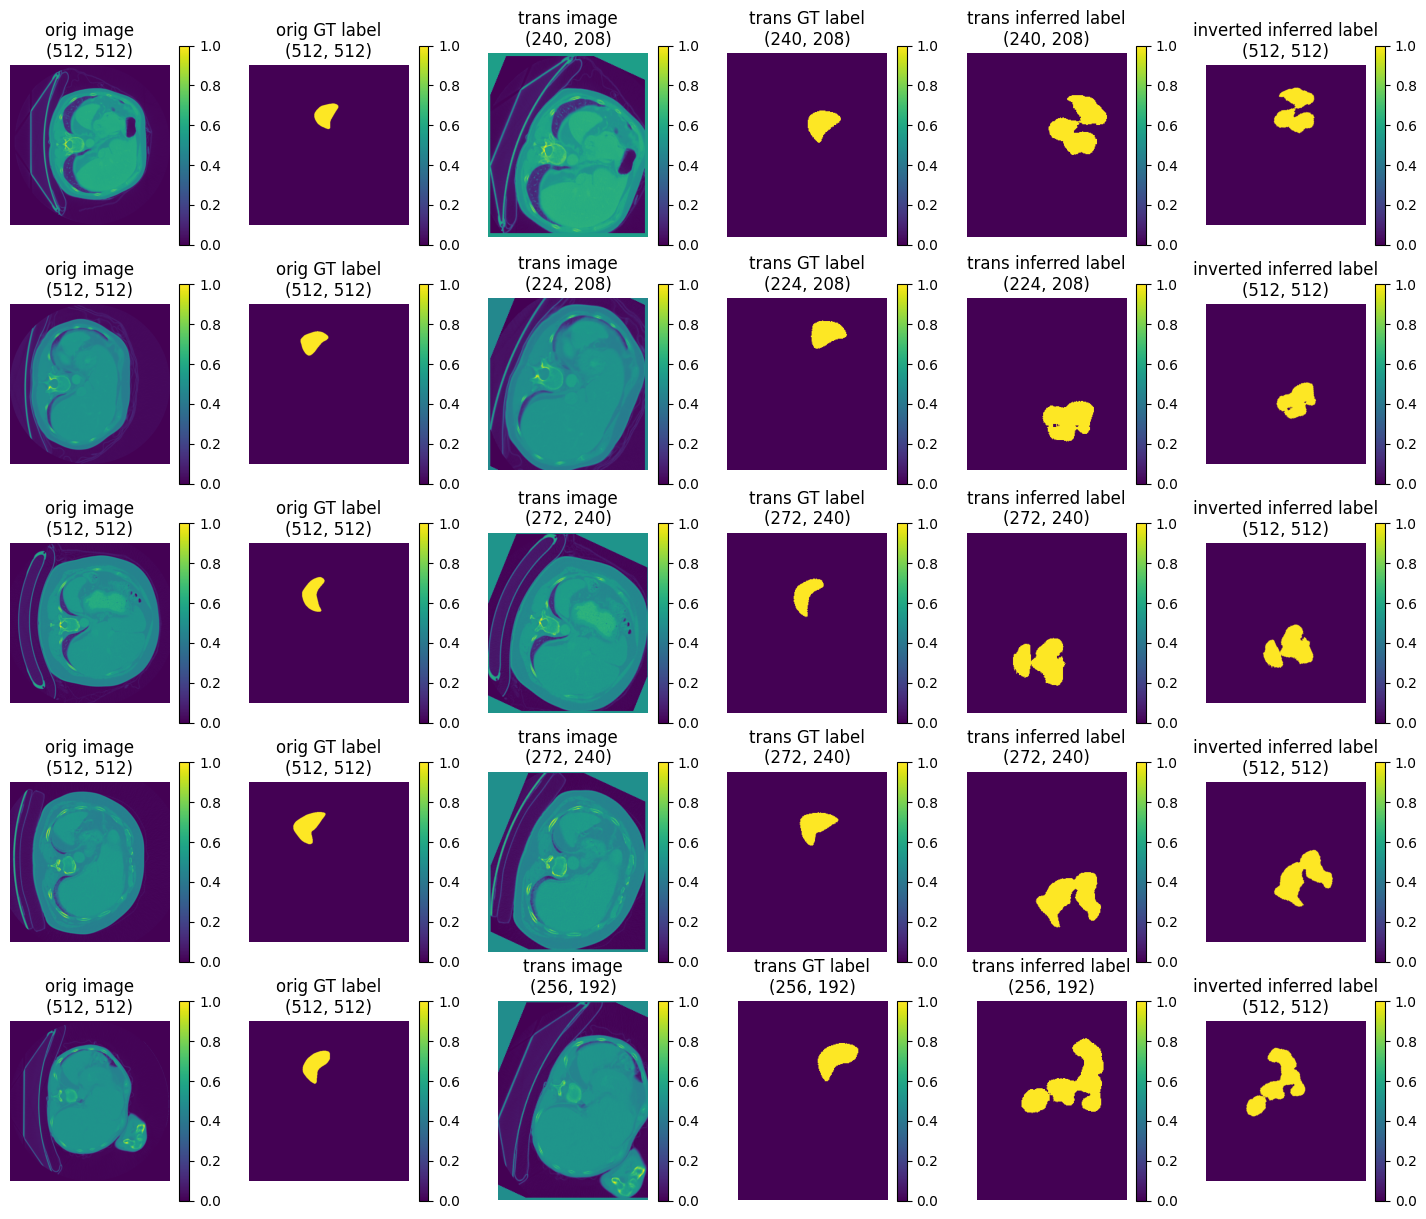

In [42]:
%matplotlib inline
# Need minimal transforms just to be able to show the unmodified originals
minimal_transforms = Compose(
    [
        LoadImaged(keys, image_only=True),
        Lambdad("label", lambda x: (x > 0).to(torch.float)),
        ScaleIntensityd("image"),
    ]
)

to_imshow = []
for file in np.random.choice(val_files, size=5, replace=False):
    unmodified_data = minimal_transforms(file)
    transformed_data = val_transforms(file)
    _img = pad_list_data_collate([transformed_data["image"].to(device)])
    seg = infer_seg(_img, model)[0].detach().cpu()
    seg.applied_operations = transformed_data["label"].applied_operations
    seg_dict = {"label": seg}
    with allow_missing_keys_mode(val_transforms):
        inverted_seg = val_transforms.inverse(seg_dict)
    to_imshow.append(
        {
            "orig image": unmodified_data["image"],
            "orig GT label": unmodified_data["label"],
            "trans image": transformed_data["image"],
            "trans GT label": transformed_data["label"],
            "trans inferred label": seg,
            "inverted inferred label": inverted_seg["label"],
        }
    )
imshows(to_imshow)

## Inversa por lotes

Igual que antes, pero esta vez tenemos todo un lote de datos y lo invertimos con `BatchInverseTransform`.

In [43]:
val_loader = DataLoader(val_ds, batch_size=5, num_workers=0, collate_fn=pad_list_data_collate)
batch_val = first(val_loader)
batch_infer = torch.sigmoid(sliding_window_inference(batch_val["image"].to(device), (96, 96), 4, model))
batch_infer.applied_operations = batch_val["label"].applied_operations
segs_dict = {"label": batch_infer}
batch_inverter = BatchInverseTransform(val_transforms, val_loader)
with allow_missing_keys_mode(val_transforms):
    fwd_bck_batch_labels = batch_inverter(segs_dict)

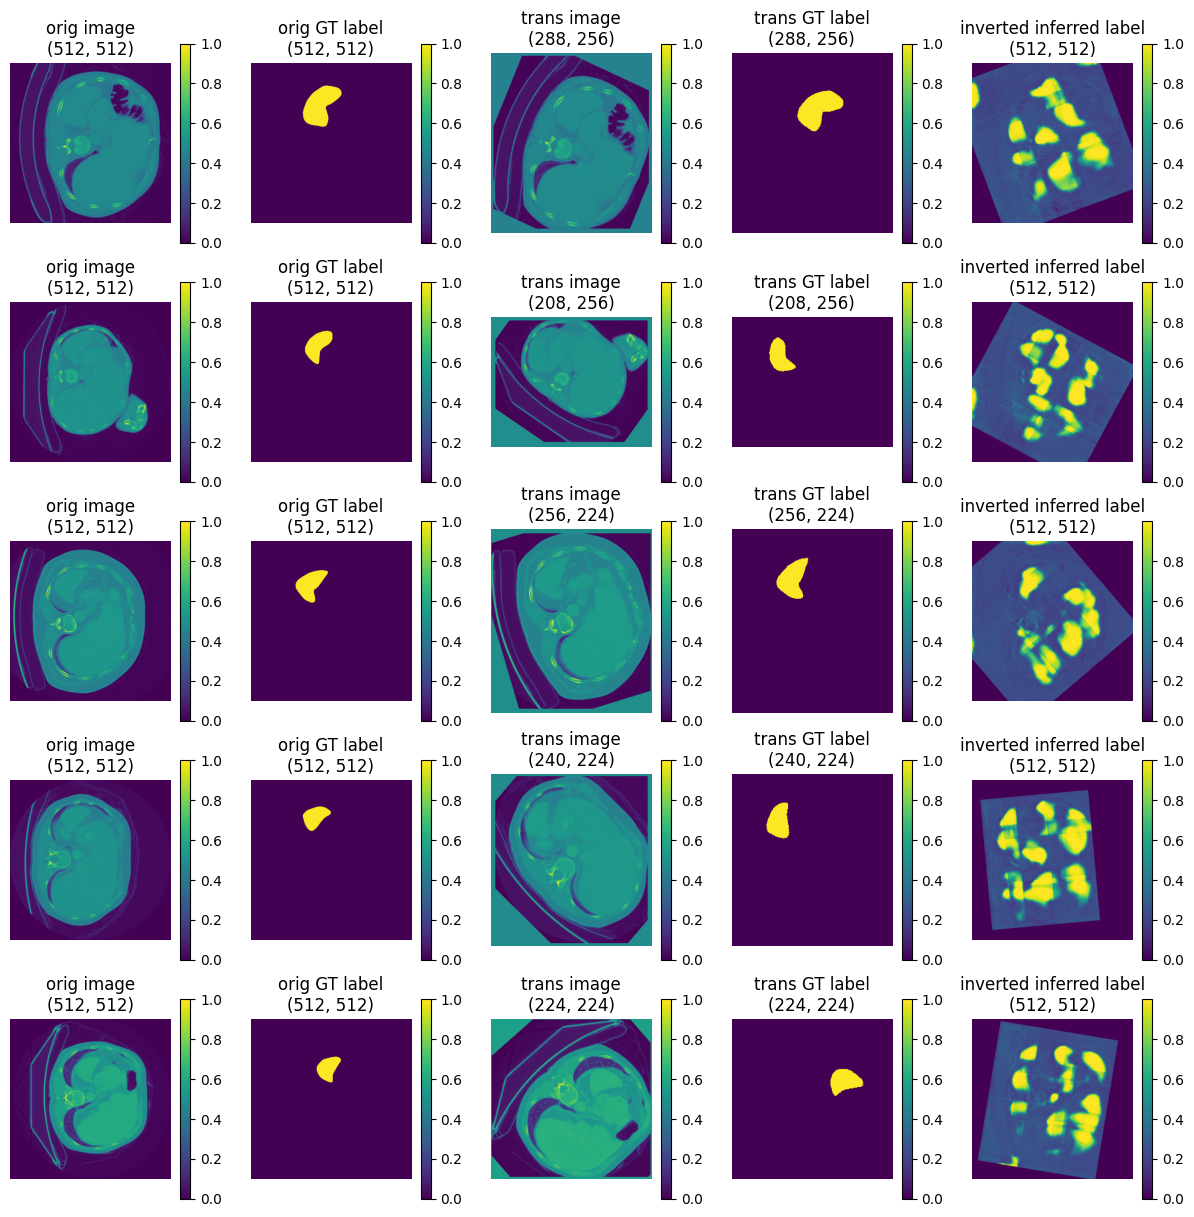

In [44]:
# visualise it
batch_val["label"].meta["filename_or_obj"]
to_imshow = []
for idx, inverted_seg in enumerate(fwd_bck_batch_labels):
    file = {
        "image": batch_val["image"].meta["filename_or_obj"][idx],
        "label": batch_val["label"].meta["filename_or_obj"][idx],
    }
    unmodified_data = minimal_transforms(file)
    transformed_data = val_transforms(file)

    to_imshow.append(
        {
            "orig image": unmodified_data["image"],
            "orig GT label": unmodified_data["label"],
            "trans image": transformed_data["image"],
            "trans GT label": transformed_data["label"],
            "inverted inferred label": inverted_seg["label"],
        }
    )
imshows(to_imshow)

## Aumentaciones en tiempo de prueba

Para las aumentaciones en tiempo de prueba, necesitamos indicar qué transformaciones aplicar (`val_transforms`), así como cómo extraer la salida (inferir las segmentaciones).

Luego parametrizamos `num_examples`, y la red se llamará este número de veces, resultando en segmentaciones diferentes debido a las transformaciones aleatorias. La inversa se aplica a cada segmentación y los resultados se promedian.

Se devuelven la moda, media, desviación estándar y el coeficiente de variación de volumen.

100%|██████████| 2/2 [00:00<00:00,  7.00it/s]


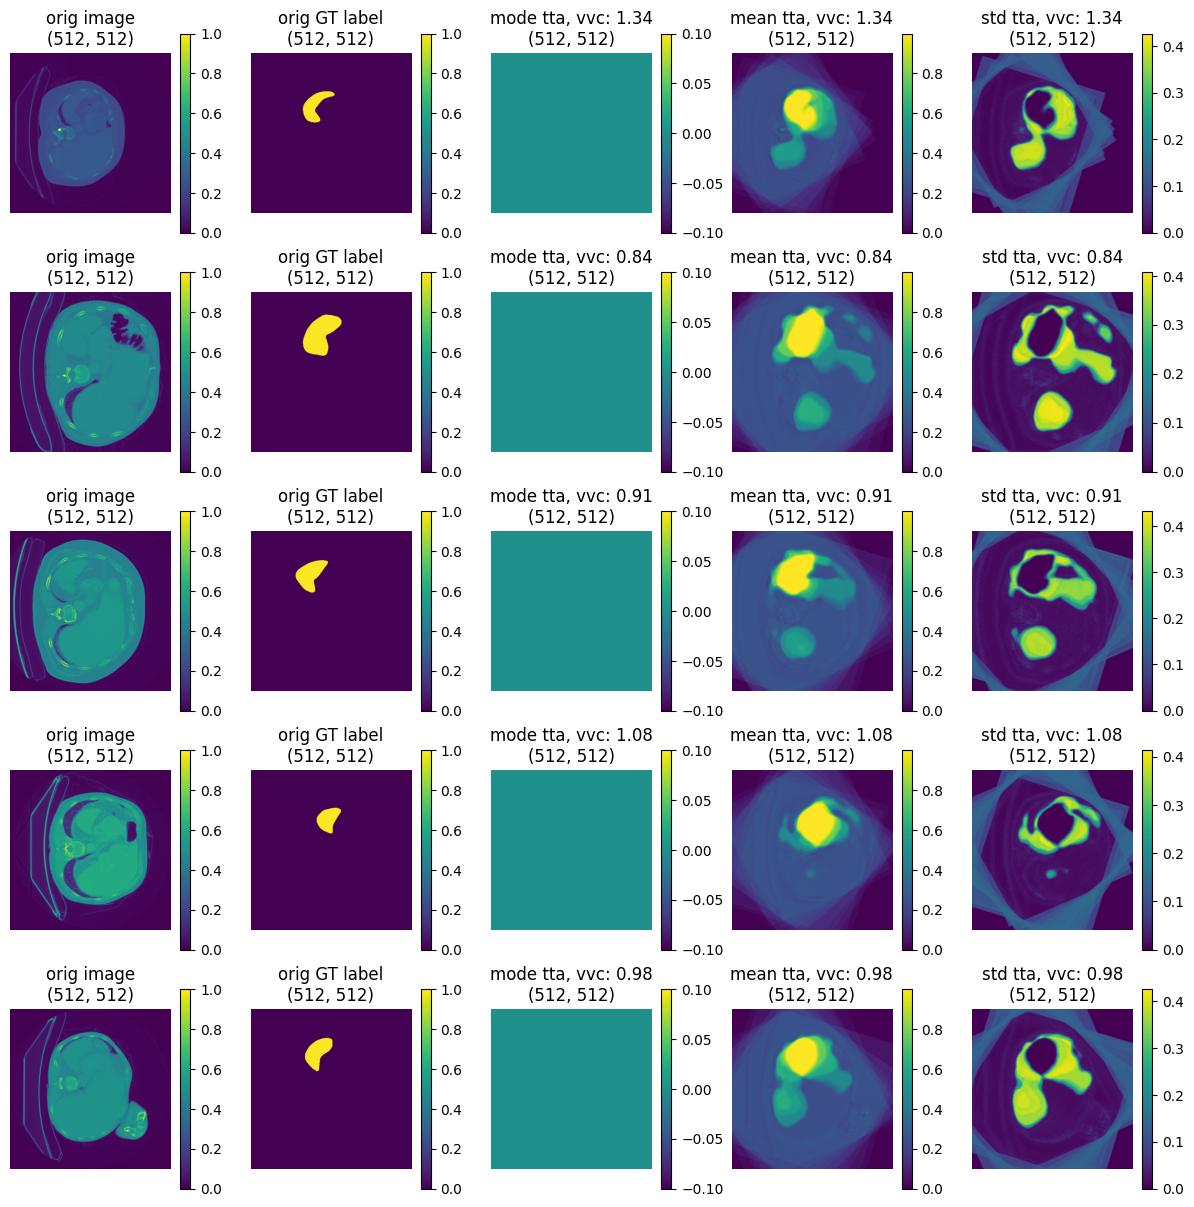

In [45]:
tt_aug = TestTimeAugmentation(
    val_transforms, batch_size=5, num_workers=0, inferrer_fn=lambda x: torch.sigmoid(model(x)), device=device
)

to_imshow = []

# Get images
for file in np.random.choice(val_files, size=5, replace=False):
    mode_tta, mean_tta, std_tta, vvc_tta = tt_aug(file, num_examples=10)
    unmodified_data = minimal_transforms(file)

    to_imshow.append(
        {
            "orig image": unmodified_data["image"],
            "orig GT label": unmodified_data["label"],
            "mode tta, vvc: %.2f" % vvc_tta: mode_tta,
            "mean tta, vvc: %.2f" % vvc_tta: mean_tta,
            "std tta, vvc: %.2f" % vvc_tta: std_tta,
        }
    )
imshows(to_imshow)